# ScoreSight: Unified Model Training Pipeline

**Author:** Prathamesh Fuke  
**Project:** EPL Football Analytics & Prediction  
**Branch:** Prathamesh_Fuke  
**Date:** November 13, 2025

## Notebook Overview

This notebook consolidates all model training tasks from the original 7 problem-specific notebooks (08, 10-14) into a single, comprehensive training pipeline.

### Problem Statements Covered:

| Problem | Type | Target | Dataset | Metric |
|---------|------|--------|---------|--------|
| **PS1** | Classification | League Champion | Points Tally | F1-Macro |
| **PS2** | Classification | Match Winner (H/NH) | Match Winner | F1-Macro |
| **PS3** | Regression | Top Scorer Goals | Top Scorer | MAE, R² |
| **PS4** | Regression | Total Points | Points Tally | MAE, R² |
| **PS5** | Classification | Match Result (H/D/A) | Raw Match | F1-Macro |
| **v1** | Regression | Home Goals (FTHG) | Engineered Match v3 | MAE |

### Key Features:
- ✅ **Temporal Cross-Validation** - Respects time series nature of sports data
- ✅ **Data Leakage Prevention** - Removes future information (e.g., `points_per_game`)
- ✅ **Hyperparameter Tuning** - RandomizedSearchCV / GridSearchCV for optimization
- ✅ **Model Persistence** - Saves best models and metadata for deployment
- ✅ **Comprehensive Evaluation** - Final comparison across all problem statements

### Expected Outputs:
- `models/ps1_league_winner_*.joblib` & `*.json`
- `models/ps2_match_winner_*.joblib` & `*.json`
- `models/ps3_top_scorer_*.joblib` & `*.json`
- `models/ps4_total_points_*.joblib` & `*.json`
- `models/ps5_match_result_*.joblib` & `*.json`
- `data/engineered/model_training_summary_v1.json`
- `visualizations/final_model_performance_comparison.png`

---

## Setup & Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from pathlib import Path
import warnings
import time
import os

# Sklearn imports
from sklearn.model_selection import (
    GridSearchCV, RandomizedSearchCV, cross_val_score,
    TimeSeriesSplit, StratifiedKFold, train_test_split
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    RandomForestClassifier, GradientBoostingClassifier
)
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    mean_absolute_percentage_error,
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Imbalanced Learn
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMBLEARN_AVAILABLE = True
except ImportError:
    IMBLEARN_AVAILABLE = False
    print("⚠️  Imbalanced-learn (SMOTE) not installed. Will proceed without it.")

# XGBoost and LightGBM
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False
    print("⚠️  XGBoost not installed.")

try:
    import lightgbm as lgb
    LGB_AVAILABLE = True
except ImportError:
    LGB_AVAILABLE = False
    print("⚠️  LightGBM not installed.")

# --- Global Configuration ---

# Set working directory
# All paths will be relative to this
try:
    os.chdir('d:\\ScoreSight')
    print(f"Working directory set to: {os.getcwd()}")
except FileNotFoundError:
    print(f"⚠️  Could not change directory. Assuming paths are relative to current location.")

# Define common paths
MODELS_DIR = Path('models')
DATA_RAW_DIR = Path('../data/raw') # From 14_
DATA_FINAL_DIR = Path('data/final')
DATA_CORRECTED_DIR = Path('data/corrected')
DATA_ENGINEERED_DIR = Path('data/engineered')
DATASETS_DIR = Path('../datasets') # From 11_
VIZ_DIR = Path('../visualizations')

# Create directories
MODELS_DIR.mkdir(exist_ok=True)
DATA_CORRECTED_DIR.mkdir(exist_ok=True)
VIZ_DIR.mkdir(exist_ok=True)

# Set display options
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("\n✓ All libraries imported and paths configured.")

Working directory set to: d:\ScoreSight

✓ All libraries imported and paths configured.


In [9]:
# --- 1.1: PS1 - Load Data ---
print("\n" + "="*80)
print("PART 1: PS1 - League Winner Prediction")
print("="*80)

DATA_FILE_PS1 = DATA_ENGINEERED_DIR / 'data_engineered_league_points.csv'
TARGET_COL_PS1 = 'target_champion'

print(f"Loading dataset: {DATA_FILE_PS1}")
try:
    df_ps1 = pd.read_csv(DATA_FILE_PS1)
    print(f"Dataset shape: {df_ps1.shape}")
    print(f"Columns: {df_ps1.columns.tolist()}")
except FileNotFoundError:
    print(f"❌ ERROR: File not found at {DATA_FILE_PS1}. Skipping this section.")
    df_ps1 = None

if df_ps1 is not None:
    # --- 1.2: PS1 - Feature and Target Definition (Leakage Corrected) ---
    LEAKAGE_COLS_PS1 = [
        'points_per_game',          # Directly calculated from target_total_points
        'target_total_points',      # A target variable itself
        'target_league_position',   # Another target variable
        'target_champion'           # The primary target for this problem statement
    ]
    
    feature_cols_ps1 = [
        col for col in df_ps1.columns
        if col not in LEAKAGE_COLS_PS1 and col not in ['season_encoded', 'team_encoded']
    ]
    
    print("\n--- PS1: Feature and Target Definition ---")
    print(f"Target column: '{TARGET_COL_PS1}'")
    print(f"Feature columns ({len(feature_cols_ps1)}): {feature_cols_ps1}")
    print(f"Leakage columns removed: {LEAKAGE_COLS_PS1}")

    # --- 1.3: PS1 - Temporal Train-Test Split ---
    df_sorted_ps1 = df_ps1.sort_values('season_encoded').reset_index(drop=True)
    
    X_ps1 = df_sorted_ps1[feature_cols_ps1]
    y_ps1 = df_sorted_ps1[TARGET_COL_PS1]
    
    seasons_ps1 = df_sorted_ps1['season_encoded'].unique()
    
    # Use the last season for testing, and all prior seasons for training
    test_season_ps1 = seasons_ps1[-1]
    train_seasons_ps1 = seasons_ps1[:-1]
    
    train_mask_ps1 = df_sorted_ps1['season_encoded'].isin(train_seasons_ps1)
    test_mask_ps1 = df_sorted_ps1['season_encoded'] == test_season_ps1
    
    X_train_ps1, y_train_ps1 = X_ps1[train_mask_ps1], y_ps1[train_mask_ps1]
    X_test_ps1, y_test_ps1 = X_ps1[test_mask_ps1], y_ps1[test_mask_ps1]
    
    print("\n--- PS1: Temporal Split Details ---")
    print(f"Training seasons: {train_seasons_ps1.tolist()}")
    print(f"Test season: {test_season_ps1}")
    print(f"Training set size: {X_train_ps1.shape[0]} samples")
    print(f"Test set size: {X_test_ps1.shape[0]} samples")
    print(f"Champions in training set: {y_train_ps1.sum()}")
    print(f"Champions in test set: {y_test_ps1.sum()}")

    # --- 1.4: PS1 - Model Training Pipeline ---
    def create_pipeline_ps1(model):
        return Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('model', model)
        ])
    
    models_ps1 = {
        'GradientBoosting': GradientBoostingClassifier(random_state=42),
        'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced')
    }
    if XGB_AVAILABLE:
        models_ps1['XGBoost'] = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    
    param_grids_ps1 = {
        'GradientBoosting': {
            'model__n_estimators': [100, 200], 'model__learning_rate': [0.05, 0.1], 'model__max_depth': [3, 5]
        },
        'RandomForest': {
            'model__n_estimators': [100, 200], 'model__max_depth': [5, 10, None], 'model__min_samples_leaf': [1, 2, 4]
        },
        'XGBoost': {
            'model__n_estimators': [100, 200], 'model__learning_rate': [0.05, 0.1], 'model__max_depth': [3, 5],
            'model__scale_pos_weight': [len(y_train_ps1[y_train_ps1==0]) / len(y_train_ps1[y_train_ps1==1])]
        }
    }
    
    n_splits_ps1 = min(len(train_seasons_ps1) - 1, 5)
    tscv_ps1 = TimeSeriesSplit(n_splits=n_splits_ps1)
    
    print(f"\n--- PS1: Training Models with Temporal CV ({n_splits_ps1} splits) ---")
    
    results_ps1 = {}
    for name, model in models_ps1.items():
        print(f"Training {name}...")
        pipeline = create_pipeline_ps1(model)
        search = RandomizedSearchCV(
            estimator=pipeline, param_distributions=param_grids_ps1[name],
            n_iter=10, cv=tscv_ps1, scoring='f1_macro', n_jobs=-1, random_state=42
        )
        search.fit(X_train_ps1, y_train_ps1)
        y_pred = search.predict(X_test_ps1)
        y_proba = search.predict_proba(X_test_ps1)[:, 1]
        
        results_ps1[name] = {
            'model': search.best_estimator_, 'best_params': search.best_params_,
            'accuracy': accuracy_score(y_test_ps1, y_pred),
            'f1_macro': f1_score(y_test_ps1, y_pred, average='macro'),
            'roc_auc': roc_auc_score(y_test_ps1, y_proba),
            'report': classification_report(y_test_ps1, y_pred, zero_division=0),
            'confusion_matrix': confusion_matrix(y_test_ps1, y_pred)
        }
        print(f"  Done. Best F1 (macro) on CV: {search.best_score_:.4f}")

    # --- 1.5: PS1 - Results and Model Saving ---
    best_model_name_ps1 = max(results_ps1, key=lambda name: results_ps1[name]['f1_macro'])
    best_model_data_ps1 = results_ps1[best_model_name_ps1]
    
    print("\n--- PS1: Model Performance on Hold-out Test Set ---")
    print(f"🏆 Best Model: {best_model_name_ps1}")
    print(f"  Accuracy: {best_model_data_ps1['accuracy']:.4f}")
    print(f"  F1 (Macro): {best_model_data_ps1['f1_macro']:.4f}")
    print(f"  ROC AUC: {best_model_data_ps1['roc_auc']:.4f}")
    print("  Confusion Matrix:\n", best_model_data_ps1['confusion_matrix'])
    
    model_filename_ps1 = MODELS_DIR / 'ps1_league_winner_best_model.joblib'
    joblib.dump(best_model_data_ps1['model'], model_filename_ps1)
    
    metadata_ps1 = {
        'problem_statement': 'PS1: League Winner Prediction',
        'model_type': best_model_name_ps1,
        'performance_metrics': {
            'accuracy': best_model_data_ps1['accuracy'],
            'f1_macro': best_model_data_ps1['f1_macro'],
            'roc_auc': best_model_data_ps1['roc_auc']
        },
        'features': feature_cols_ps1,
        'target': TARGET_COL_PS1,
        'temporal_split': {
            'train_seasons': train_seasons_ps1.tolist(),
            'test_season': int(test_season_ps1)
        }
    }
    metadata_filename_ps1 = MODELS_DIR / 'ps1_league_winner_metadata.json'
    with open(metadata_filename_ps1, 'w') as f:
        json.dump(metadata_ps1, f, indent=4)
        
    print(f"\nModel saved to: {model_filename_ps1}")
    print(f"Metadata saved to: {metadata_filename_ps1}")


PART 1: PS1 - League Winner Prediction
Loading dataset: data\engineered\data_engineered_league_points.csv
Dataset shape: (180, 22)
Columns: ['matches_played', 'points_per_game', 'goals_scored', 'goals_conceded', 'goal_difference', 'target_total_points', 'target_league_position', 'target_champion', 'season_encoded', 'team_encoded', 'goal_conversion_efficiency', 'defensive_solidity', 'offensive_power', 'offensive_dominance', 'gd_squared', 'positive_gd_indicator', 'elite_performance', 'title_contender', 'mid_table', 'goals_distribution_variance', 'performance_volatility', 'projected_upper_tier']

--- PS1: Feature and Target Definition ---
Target column: 'target_champion'
Feature columns (16): ['matches_played', 'goals_scored', 'goals_conceded', 'goal_difference', 'goal_conversion_efficiency', 'defensive_solidity', 'offensive_power', 'offensive_dominance', 'gd_squared', 'positive_gd_indicator', 'elite_performance', 'title_contender', 'mid_table', 'goals_distribution_variance', 'performanc

In [12]:
# --- 2.1: PS3 - Load Data ---
print("\n" + "="*80)
print("PART 2: PS3 - Top Scorer Prediction")
print("="*80)

DATA_FILE_PS3 = DATA_ENGINEERED_DIR / 'data_engineered_top_scorer.csv'
TARGET_COL_PS3 = 'goals' # The original file uses 'goals_scored', this one uses 'goals'
MODEL_NAME_PS3 = 'ps3_top_scorer_best_model.joblib'
METADATA_NAME_PS3 = 'ps3_top_scorer_metadata.json'

print(f"Loading dataset: {DATA_FILE_PS3}")
try:
    df_ps3 = pd.read_csv(DATA_FILE_PS3)
    print(f"✓ Successfully loaded PS3 data. Shape: {df_ps3.shape}")
except FileNotFoundError:
    print(f"❌ ERROR: File not found at {DATA_FILE_PS3}. Skipping this section.")
    df_ps3 = None

if df_ps3 is not None:
    # --- 2.2: PS3 - Feature and Target Definition ---
    y_ps3 = df_ps3[TARGET_COL_PS3]
    # Exclude all identifiers and other potential targets
    exclude_cols_ps3 = [
        'goals', 'non_penalty_goals', 'penalty_goals_made', # Targets
        'player', 'team', 'season', 'nationality', 'position', # Identifiers
        'player_encoded', 'nation_encoded', 'position_encoded' # Encoded IDs
    ]
    feature_cols_ps3 = [col for col in df_ps3.columns if col not in exclude_cols_ps3 and df_ps3[col].dtype in ['float64', 'int64']]

    print(f"\n--- PS3: Feature and Target Definition ---")
    print(f"Target column: '{TARGET_COL_PS3}'")
    print(f"Feature columns ({len(feature_cols_ps3)}): {feature_cols_ps3[:5]}...")

    # --- 2.3: PS3 - Standard Train-Test Split (no season data available) ---
    df_sorted_ps3 = df_ps3.reset_index(drop=True)
    
    X_ps3 = df_sorted_ps3[feature_cols_ps3]
    y_ps3 = df_sorted_ps3[TARGET_COL_PS3]
    
    # Use standard 80/20 split since no season info available
    split_idx = int(len(df_sorted_ps3) * 0.8)
    
    X_train_ps3, y_train_ps3 = X_ps3.iloc[:split_idx], y_ps3.iloc[:split_idx]
    X_test_ps3, y_test_ps3 = X_ps3.iloc[split_idx:], y_ps3.iloc[split_idx:]
    
    print("\n--- PS3: Train-Test Split Details ---")
    print(f"Training set size: {X_train_ps3.shape[0]} samples")
    print(f"Test set size: {X_test_ps3.shape[0]} samples")

    # --- 2.4: PS3 - Model Training Pipeline ---
    def create_pipeline_ps3(model):
        return Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', model)
        ])

    models_to_train_ps3 = {
        'Ridge': Ridge(random_state=42),
        'Lasso': Lasso(random_state=42, max_iter=10000),
        'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1),
        'GradientBoosting': GradientBoostingRegressor(random_state=42)
    }
    if XGB_AVAILABLE:
        models_to_train_ps3['XGBoost'] = xgb.XGBRegressor(random_state=42, n_jobs=-1)
    if LGB_AVAILABLE:
        models_to_train_ps3['LightGBM'] = lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)

    # Use param grids from notebook 12
    param_grids_ps3 = {
        'Ridge': {'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
        'Lasso': {'model__alpha': [0.001, 0.01, 0.1, 1, 10]},
        'RandomForest': {'model__n_estimators': [100, 200, 300], 'model__max_depth': [10, 15, 20, None], 'model__min_samples_split': [2, 5], 'model__min_samples_leaf': [1, 2]},
        'GradientBoosting': {'model__n_estimators': [100, 200, 300], 'model__learning_rate': [0.01, 0.05, 0.1], 'model__max_depth': [5, 7, 9], 'model__subsample': [0.8, 0.9]},
        'XGBoost': {'model__n_estimators': [100, 200, 300], 'model__learning_rate': [0.01, 0.05, 0.1], 'model__max_depth': [5, 7, 9], 'model__subsample': [0.8, 0.9]},
        'LightGBM': {'model__n_estimators': [100, 200, 300], 'model__learning_rate': [0.01, 0.05, 0.1], 'model__num_leaves': [30, 50, 70]}
    }

    # Use standard K-Fold since no temporal dimension
    from sklearn.model_selection import KFold
    kfold_ps3 = KFold(n_splits=5, shuffle=True, random_state=42)

    print(f"\n--- PS3: Training Models with K-Fold CV (5 splits) ---")
    
    results_ps3 = {}
    trained_models_ps3 = {}

    for model_name, model in models_to_train_ps3.items():
        if model_name not in param_grids_ps3: continue
        print(f"Training {model_name}...")
        pipeline = create_pipeline_ps3(model)
        search = RandomizedSearchCV(
            pipeline, param_grids_ps3[model_name], n_iter=20, cv=kfold_ps3,
            scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42, verbose=0
        )
        search.fit(X_train_ps3, y_train_ps3)
        y_pred = search.predict(X_test_ps3)
        
        results_ps3[model_name] = {
            'best_params': search.best_params_,
            'cv_mae': float(-search.best_score_),
            'test_mae': float(mean_absolute_error(y_test_ps3, y_pred)),
            'test_rmse': float(np.sqrt(mean_squared_error(y_test_ps3, y_pred))),
            'test_r2': float(r2_score(y_test_ps3, y_pred))
        }
        trained_models_ps3[model_name] = search.best_estimator_
        print(f"  [CV] MAE: {-search.best_score_:.4f} | [TEST] MAE: {results_ps3[model_name]['test_mae']:.4f}")

    # --- 2.5: PS3 - Results and Model Saving ---
    best_model_name_ps3 = min(results_ps3, key=lambda x: results_ps3[x]['test_mae'])
    best_metrics_ps3 = results_ps3[best_model_name_ps3]

    print(f"\n[WINNER] Best Model: {best_model_name_ps3}")
    print(f"[WINNER] Test MAE: {best_metrics_ps3['test_mae']:.4f}")
    print(f"[WINNER] Test R²: {best_metrics_ps3['test_r2']:.4f}")

    best_model_path_ps3 = MODELS_DIR / MODEL_NAME_PS3
    joblib.dump(trained_models_ps3[best_model_name_ps3], best_model_path_ps3)

    summary_ps3 = {
        'problem_statement': 'PS3: Top Scorer Goals Prediction',
        'task_type': 'Regression',
        'best_model': best_model_name_ps3,
        'best_test_mae': best_metrics_ps3['test_mae'],
        'best_test_r2': best_metrics_ps3['test_r2'],
        'data': {
            'path': str(DATA_FILE_PS3),
            'train_size': len(X_train_ps3),
            'test_size': len(X_test_ps3),
            'n_features': len(feature_cols_ps3)
        },
        'features': feature_cols_ps3,
        'cv_strategy': f'KFold (n_splits=5)',
        'best_params': best_metrics_ps3['best_params']
    }

    summary_path_ps3 = MODELS_DIR / METADATA_NAME_PS3
    with open(summary_path_ps3, 'w') as f:
        json.dump(summary_ps3, f, indent=2, default=str)

    print(f"[SAVE] Best Model ({best_model_name_ps3}) -> {best_model_path_ps3}")
    print(f"[SAVE] Metadata -> {summary_path_ps3}")


PART 2: PS3 - Top Scorer Prediction
Loading dataset: data\engineered\data_engineered_top_scorer.csv
✓ Successfully loaded PS3 data. Shape: (2070, 44)

--- PS3: Feature and Target Definition ---
Target column: 'goals'
Feature columns (38): ['age', 'matches_played', 'assists', 'penalty_attempts', 'xg']...

--- PS3: Train-Test Split Details ---
Training set size: 1656 samples
Test set size: 414 samples

--- PS3: Training Models with K-Fold CV (5 splits) ---
Training Ridge...
  [CV] MAE: 0.0001 | [TEST] MAE: 0.0000
Training Lasso...
  [CV] MAE: 0.0012 | [TEST] MAE: 0.0012
Training RandomForest...
  [CV] MAE: 0.0713 | [TEST] MAE: 0.0574
Training GradientBoosting...
  [CV] MAE: 0.0713 | [TEST] MAE: 0.0574
Training GradientBoosting...
  [CV] MAE: 0.0623 | [TEST] MAE: 0.0548
Training XGBoost...
  [CV] MAE: 0.0623 | [TEST] MAE: 0.0548
Training XGBoost...
  [CV] MAE: 0.0629 | [TEST] MAE: 0.0559
Training LightGBM...
  [CV] MAE: 0.0629 | [TEST] MAE: 0.0559
Training LightGBM...
  [CV] MAE: 0.1066 

In [13]:
# --- 3.1: PS4 - Load Data ---
print("\n" + "="*80)
print("PART 3: PS4 - Total Points Prediction")
print("="*80)

DATA_FILE_PS4 = DATA_ENGINEERED_DIR / 'data_engineered_league_points.csv'
TARGET_COL_PS4 = 'target_total_points'
MODEL_NAME_PS4 = 'ps4_total_points_best_model.joblib'
METADATA_NAME_PS4 = 'ps4_total_points_metadata.json'

print(f"Loading dataset: {DATA_FILE_PS4}")
try:
    df_ps4 = pd.read_csv(DATA_FILE_PS4)
    df_ps4 = df_ps4.sort_values(by='season_encoded').reset_index(drop=True)
    print(f"Dataset shape: {df_ps4.shape}")
except FileNotFoundError:
    print(f"❌ ERROR: File not found at {DATA_FILE_PS4}. Skipping this section.")
    df_ps4 = None

if df_ps4 is not None:
    # --- 3.2: PS4 - Feature and Target Definition (Leakage Corrected) ---
    y_ps4 = df_ps4[TARGET_COL_PS4]
    
    # CRITICAL: Remove 'points_per_game' and other targets
    leakage_cols_ps4 = ['points_per_game', 'target_total_points', 'target_league_position', 'target_champion']
    feature_cols_ps4 = [
        col for col in df_ps4.columns 
        if col not in leakage_cols_ps4 and col not in ['team', 'season_encoded', 'team_encoded']
    ]

    print("\n--- PS4: Feature and Target Definition ---")
    print(f"Target column: '{TARGET_COL_PS4}'")
    print(f"Feature columns ({len(feature_cols_ps4)}): {feature_cols_ps4}")
    
    X_ps4 = df_ps4[feature_cols_ps4]

    # --- 3.3: PS4 - Temporal Train-Test Split ---
    seasons_ps4 = df_ps4['season_encoded'].unique()
    test_season_ps4 = seasons_ps4[-1]
    train_seasons_ps4 = seasons_ps4[:-1]
    
    train_mask_ps4 = df_ps4['season_encoded'].isin(train_seasons_ps4)
    test_mask_ps4 = df_ps4['season_encoded'] == test_season_ps4
    
    X_train_ps4, y_train_ps4 = X_ps4[train_mask_ps4], y_ps4[train_mask_ps4]
    X_test_ps4, y_test_ps4 = X_ps4[test_mask_ps4], y_ps4[test_mask_ps4]
    
    print("\n--- PS4: Temporal Split Details ---")
    print(f"Training seasons: {train_seasons_ps4.tolist()}")
    print(f"Test season: {test_season_ps4}")
    print(f"Training set size: {X_train_ps4.shape[0]} samples")
    print(f"Test set size: {X_test_ps4.shape[0]} samples")

    # --- 3.4: PS4 - Model Training Pipeline ---
    def create_pipeline_ps4(model):
        return Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', model)
        ])

    models_to_train_ps4 = {
        'Ridge': Ridge(random_state=42),
        'Lasso': Lasso(random_state=42, max_iter=10000),
        'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1),
        'GradientBoosting': GradientBoostingRegressor(random_state=42)
    }
    if XGB_AVAILABLE:
        models_to_train_ps4['XGBoost'] = xgb.XGBRegressor(random_state=42, n_jobs=-1)
    if LGB_AVAILABLE:
        models_to_train_ps4['LightGBM'] = lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)

    # Use param grids from notebook 13
    param_grids_ps4 = {
        'Ridge': {'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
        'Lasso': {'model__alpha': [0.001, 0.01, 0.1, 1, 10]},
        'RandomForest': {'model__n_estimators': [50, 100, 150], 'model__max_depth': [5, 10, 15, None], 'model__min_samples_split': [2, 5], 'model__min_samples_leaf': [1, 2]},
        'GradientBoosting': {'model__n_estimators': [50, 100, 150], 'model__learning_rate': [0.01, 0.05, 0.1], 'model__max_depth': [3, 5, 7], 'model__subsample': [0.8, 0.9]},
        'XGBoost': {'model__n_estimators': [50, 100, 150], 'model__learning_rate': [0.01, 0.05, 0.1], 'model__max_depth': [3, 5, 7], 'model__subsample': [0.8, 0.9]},
        'LightGBM': {'model__n_estimators': [50, 100, 150], 'model__learning_rate': [0.01, 0.05, 0.1], 'model__num_leaves': [20, 30, 40]}
    }
    
    n_splits_ps4 = min(len(train_seasons_ps4) - 1, 5)
    tscv_ps4 = TimeSeriesSplit(n_splits=n_splits_ps4)
    
    print(f"\n--- PS4: Training Models with Temporal CV ({n_splits_ps4} splits) ---")
    
    results_ps4 = {}
    trained_models_ps4 = {}
    
    for model_name, model in models_to_train_ps4.items():
        if model_name not in param_grids_ps4: continue
        print(f"Training {model_name}...")
        pipeline = create_pipeline_ps4(model)
        search = RandomizedSearchCV(
            pipeline, param_grids_ps4[model_name], n_iter=20, cv=tscv_ps4,
            scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42, verbose=0
        )
        search.fit(X_train_ps4, y_train_ps4)
        y_pred = search.predict(X_test_ps4)
        
        results_ps4[model_name] = {
            'best_params': search.best_params_,
            'cv_mae': float(-search.best_score_),
            'test_mae': float(mean_absolute_error(y_test_ps4, y_pred)),
            'test_rmse': float(np.sqrt(mean_squared_error(y_test_ps4, y_pred))),
            'test_r2': float(r2_score(y_test_ps4, y_pred))
        }
        trained_models_ps4[model_name] = search.best_estimator_
        print(f"  [CV] MAE: {-search.best_score_:.4f} | [TEST] MAE: {results_ps4[model_name]['test_mae']:.4f}")

    # --- 3.5: PS4 - Results and Model Saving ---
    best_model_name_ps4 = min(results_ps4, key=lambda x: results_ps4[x]['test_mae'])
    best_metrics_ps4 = results_ps4[best_model_name_ps4]

    print(f"\n[WINNER] Best Model: {best_model_name_ps4}")
    print(f"[WINNER] Test MAE: {best_metrics_ps4['test_mae']:.4f}")
    print(f"[WINNER] Test R²: {best_metrics_ps4['test_r2']:.4f}")

    best_model_path_ps4 = MODELS_DIR / MODEL_NAME_PS4
    joblib.dump(trained_models_ps4[best_model_name_ps4], best_model_path_ps4)
    
    summary_ps4 = {
        'problem_statement': 'PS4: Total Points Tally Prediction',
        'task_type': 'Regression',
        'best_model': best_model_name_ps4,
        'best_test_mae': best_metrics_ps4['test_mae'],
        'best_test_r2': best_metrics_ps4['test_r2'],
        'data': {
            'path': str(DATA_FILE_PS4),
            'train_size': len(X_train_ps4),
            'test_size': len(X_test_ps4),
            'n_features': len(feature_cols_ps4)
        },
        'features': feature_cols_ps4,
        'cv_strategy': f'TimeSeriesSplit (n_splits={n_splits_ps4})',
        'best_params': best_metrics_ps4['best_params']
    }

    summary_path_ps4 = MODELS_DIR / METADATA_NAME_PS4
    with open(summary_path_ps4, 'w') as f:
        json.dump(summary_ps4, f, indent=2, default=str)

    print(f"[SAVE] Best Model ({best_model_name_ps4}) -> {best_model_path_ps4}")
    print(f"[SAVE] Metadata -> {summary_path_ps4}")


PART 3: PS4 - Total Points Prediction
Loading dataset: data\engineered\data_engineered_league_points.csv
Dataset shape: (180, 22)

--- PS4: Feature and Target Definition ---
Target column: 'target_total_points'
Feature columns (16): ['matches_played', 'goals_scored', 'goals_conceded', 'goal_difference', 'goal_conversion_efficiency', 'defensive_solidity', 'offensive_power', 'offensive_dominance', 'gd_squared', 'positive_gd_indicator', 'elite_performance', 'title_contender', 'mid_table', 'goals_distribution_variance', 'performance_volatility', 'projected_upper_tier']

--- PS4: Temporal Split Details ---
Training seasons: [0, 1, 2, 3, 4, 5, 6, 7]
Test season: 8
Training set size: 160 samples
Test set size: 20 samples

--- PS4: Training Models with Temporal CV (5 splits) ---
Training Ridge...
  [CV] MAE: 3.4383 | [TEST] MAE: 3.0624
Training Lasso...
  [CV] MAE: 3.6410 | [TEST] MAE: 2.9936
Training RandomForest...
  [CV] MAE: 3.5654 | [TEST] MAE: 3.1879
Training GradientBoosting...
  [CV] 

In [14]:
# --- 4.1.1: PS2 - Load Data & Clean ---
print("\n" + "="*80)
print("PART 4a: PS2 - Match Winner (H/NH) - Advanced FE Pipeline")
print("="*80)

DATA_FILE_PS2 = Path('datasets') / 'Match Winner.csv'
MODEL_NAME_PS2 = 'ps2_match_winner_best_model_v4_ultimate.joblib'
METADATA_NAME_PS2 = 'ps2_match_winner_metadata_v4_ultimate.json'

try:
    df_ps2 = pd.read_csv(DATA_FILE_PS2)
    df_ps2['Date'] = pd.to_datetime(df_ps2['Date'], format='mixed')
    df_ps2 = df_ps2.sort_values('Date').reset_index(drop=True)
    df_ps2 = df_ps2[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]
    df_ps2.dropna(subset=['FTHG', 'FTAG', 'FTR'], inplace=True)
    print(f"PS2 data loaded and cleaned. Shape: {df_ps2.shape}")
except FileNotFoundError:
    print(f"❌ ERROR: File not found at {DATA_FILE_PS2}. Skipping this section.")
    df_ps2 = None

if df_ps2 is not None:
    # --- 4.1.2: PS2 - Advanced Feature Engineering ---
    
    # (Using the same function from Notebook 11)
    def get_advanced_features_ps2(team_history, opponent_history, h2h_history, windows, alphas):
        features = {}
        for W in windows:
            if len(team_history) >= W:
                window_df = pd.DataFrame(team_history[-W:])
                features[f'avg_gs_{W}'] = window_df['gs'].mean()
                features[f'avg_gc_{W}'] = window_df['gc'].mean()
                features[f'avg_gd_{W}'] = window_df['gd'].mean()
                features[f'avg_pts_{W}'] = window_df['pts'].mean()
            else:
                features[f'avg_gs_{W}'] = np.nan
                features[f'avg_gc_{W}'] = np.nan
                features[f'avg_gd_{W}'] = np.nan
                features[f'avg_pts_{W}'] = np.nan
        if len(team_history) > 1:
            history_df = pd.DataFrame(team_history)
            for alpha in alphas:
                features[f'ewma_gs_{alpha}'] = history_df['gs'].ewm(alpha=alpha).mean().iloc[-1]
                features[f'ewma_gc_{alpha}'] = history_df['gc'].ewm(alpha=alpha).mean().iloc[-1]
                features[f'ewma_gd_{alpha}'] = history_df['gd'].ewm(alpha=alpha).mean().iloc[-1]
        else:
            for alpha in alphas:
                features[f'ewma_gs_{alpha}'] = np.nan
                features[f'ewma_gc_{alpha}'] = np.nan
                features[f'ewma_gd_{alpha}'] = np.nan
        if len(h2h_history) > 0:
            h2h_df = pd.DataFrame(h2h_history)
            features['h2h_avg_gs'] = h2h_df['gs'].mean()
            features['h2h_avg_gc'] = h2h_df['gc'].mean()
            features['h2h_win_rate'] = (h2h_df['pts'] == 3).mean()
        else:
            features['h2h_avg_gs'] = np.nan
            features['h2h_avg_gc'] = np.nan
            features['h2h_win_rate'] = np.nan
        return features

    WINDOWS = [5, 10]
    ALPHAS = [0.1, 0.2]
    teams = pd.concat([df_ps2['HomeTeam'], df_ps2['AwayTeam']]).unique()
    team_histories = {team: [] for team in teams}
    h2h_histories = {} 
    
    new_features_list = []
    print("Starting PS2 feature engineering (EWMA, H2H)...")
    
    for index, row in df_ps2.iterrows():
        home_team, away_team = row['HomeTeam'], row['AwayTeam']
        h2h_key = tuple(sorted((home_team, away_team)))
        if h2h_key not in h2h_histories:
            h2h_histories[h2h_key] = []

        home_feats = get_advanced_features_ps2(team_histories[home_team], team_histories[away_team], h2h_histories[h2h_key], WINDOWS, ALPHAS)
        away_feats = get_advanced_features_ps2(team_histories[away_team], team_histories[home_team], h2h_histories[h2h_key], WINDOWS, ALPHAS)
        
        match_features = {}
        for key, value in home_feats.items(): match_features[f'H_{key}'] = value
        for key, value in away_feats.items(): match_features[f'A_{key}'] = value
        for W in WINDOWS: match_features[f'diff_avg_gd_{W}'] = home_feats.get(f'avg_gd_{W}') - away_feats.get(f'avg_gd_{W}')
        for alpha in ALPHAS: match_features[f'diff_ewma_gd_{alpha}'] = home_feats.get(f'ewma_gd_{alpha}') - away_feats.get(f'ewma_gd_{alpha}')
        new_features_list.append(match_features)

        # Update histories
        home_goals, away_goals = row['FTHG'], row['FTAG']
        if row['FTR'] == 'H': home_pts, away_pts = 3, 0
        elif row['FTR'] == 'A': home_pts, away_pts = 0, 3
        else: home_pts, away_pts = 1, 1
        team_histories[home_team].append({'gs': home_goals, 'gc': away_goals, 'gd': home_goals - away_goals, 'pts': home_pts})
        team_histories[away_team].append({'gs': away_goals, 'gc': home_goals, 'gd': away_goals - home_goals, 'pts': away_pts})
        h2h_histories[h2h_key].append({'team': home_team, 'gs': home_goals, 'gc': away_goals, 'pts': home_pts})
    
    features_df_ps2 = pd.DataFrame(new_features_list, index=df_ps2.index)
    df_featured_ps2 = pd.concat([df_ps2, features_df_ps2], axis=1)
    df_featured_ps2.dropna(inplace=True)
    print(f"PS2 feature engineering complete. New shape: {df_featured_ps2.shape}")

    # --- 4.1.3: PS2 - Target, Split, and Pipeline ---
    le_ps2 = LabelEncoder()
    # Note: This is BINARY classification (H vs NH)
    df_featured_ps2['FTR_encoded'] = le_ps2.fit_transform(df_featured_ps2['FTR'])
    target_mapping_ps2 = {i: l for i, l in enumerate(le_ps2.classes_)} # {0: 'H', 1: 'NH'}
    
    y_ps2 = df_featured_ps2['FTR_encoded']
    X_ps2 = df_featured_ps2.drop(columns=['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'FTR_encoded'])
    
    split_index_ps2 = int(len(df_featured_ps2) * 0.85)
    X_train_ps2, y_train_ps2 = X_ps2.iloc[:split_index_ps2], y_ps2.iloc[:split_index_ps2]
    X_test_ps2, y_test_ps2 = X_ps2.iloc[split_index_ps2:], y_ps2.iloc[split_index_ps2:]
    
    print(f"PS2 Temporal Split: Train={len(X_train_ps2)}, Test={len(X_test_ps2)}")
    print(f"PS2 Target Mapping: {target_mapping_ps2}")

    # --- 4.1.4: PS2 - Model Training ---
    def create_smote_pipeline_ps2(model):
        if IMBLEARN_AVAILABLE:
            return ImbPipeline([
                ('imputer', SimpleImputer(strategy='mean')), 
                ('scaler', StandardScaler()),
                ('smote', SMOTE(random_state=42)),
                ('model', model)
            ])
        else:
             return Pipeline([
                ('imputer', SimpleImputer(strategy='mean')), 
                ('scaler', StandardScaler()),
                ('model', model)
            ])

    models_ps2 = {'RandomForest': RandomForestClassifier(random_state=42)}
    if XGB_AVAILABLE:
        models_ps2['XGBoost'] = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss') # mlogloss for multi, logloss for binary
    
    param_grids_ps2 = {
        'RandomForest': {
            'model__n_estimators': [200, 400], 'model__max_depth': [10, 20, 30],
            'model__min_samples_leaf': [1, 2], 'model__max_features': ['sqrt', 'log2']
        },
        'XGBoost': {
            'model__n_estimators': [200, 400], 'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [5, 7], 'model__subsample': [0.8, 1.0]
        }
    }
    
    tscv_ps2 = TimeSeriesSplit(n_splits=5)
    results_ps2 = {}
    
    print(f"\n--- PS2: Training Models with GridSearchCV (Binary) ---")
    
    for name, model in models_ps2.items():
        if name not in param_grids_ps2: continue
        print(f"Training {name}...")
        pipeline = create_smote_pipeline_ps2(model)
        search = GridSearchCV(
            estimator=pipeline, param_grid=param_grids_ps2[name],
            cv=tscv_ps2, scoring='accuracy', n_jobs=-1, verbose=1
        )
        search.fit(X_train_ps2, y_train_ps2)
        y_pred = search.predict(X_test_ps2)
        
        results_ps2[name] = {
            'model': search.best_estimator_, 'best_params': search.best_params_,
            'accuracy': accuracy_score(y_test_ps2, y_pred),
            'f1_macro': f1_score(y_test_ps2, y_pred, average='macro'),
            'report': classification_report(y_test_ps2, y_pred),
            'confusion_matrix': confusion_matrix(y_test_ps2, y_pred)
        }
        print(f"  Done. Best Accuracy on CV: {search.best_score_:.4f}")

    # --- 4.1.5: PS2 - Results and Model Saving ---
    best_model_name_ps2 = max(results_ps2, key=lambda name: results_ps2[name]['accuracy'])
    best_model_data_ps2 = results_ps2[best_model_name_ps2]

    print(f"\n--- PS2: Saving Best Model: {best_model_name_ps2} ---")
    print(f"  Accuracy: {best_model_data_ps2['accuracy']:.4f}")
    print(f"  F1 (Macro): {best_model_data_ps2['f1_macro']:.4f}")

    joblib.dump(best_model_data_ps2['model'], MODELS_DIR / MODEL_NAME_PS2)
    
    metadata_ps2 = {
        "problem_statement": "PS2: Match Winner Prediction (H/NH)",
        "model_name": best_model_name_ps2,
        "features": list(X_ps2.columns),
        "target_mapping": target_mapping_ps2,
        "performance_metrics": {
            "accuracy": best_model_data_ps2['accuracy'],
            "f1_macro": best_model_data_ps2['f1_macro'],
        },
        "hyperparameters": best_model_data_ps2['best_params'],
    }
    
    with open(MODELS_DIR / METADATA_NAME_PS2, 'w') as f:
        json.dump(metadata_ps2, f, indent=4)
        
    print(f"Model saved to: {MODELS_DIR / MODEL_NAME_PS2}")
    print(f"Metadata saved to: {MODELS_DIR / METADATA_NAME_PS2}")


PART 4a: PS2 - Match Winner (H/NH) - Advanced FE Pipeline
PS2 data loaded and cleaned. Shape: (6840, 6)
Starting PS2 feature engineering (EWMA, H2H)...
PS2 feature engineering complete. New shape: (6128, 44)
PS2 Temporal Split: Train=5208, Test=920
PS2 Target Mapping: {0: 'H', 1: 'NH'}

--- PS2: Training Models with GridSearchCV (Binary) ---
Training RandomForest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
PS2 feature engineering complete. New shape: (6128, 44)
PS2 Temporal Split: Train=5208, Test=920
PS2 Target Mapping: {0: 'H', 1: 'NH'}

--- PS2: Training Models with GridSearchCV (Binary) ---
Training RandomForest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
  Done. Best Accuracy on CV: 0.6369
Training XGBoost...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
  Done. Best Accuracy on CV: 0.6369
Training XGBoost...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
  Done. Best Accuracy on CV: 0.6196

--- PS2: Saving Be

In [15]:
# --- 4.2.1: PS5 - Load Data ---
print("\n" + "="*80)
print("PART 4b: PS5 - Match Result (H/D/A) - Raw Data Pipeline")
print("="*80)

DATA_FILE_PS5 = Path('data/raw') / 'data_raw_match.csv'
MODEL_NAME_PS5 = 'ps5_match_result_model.joblib'
METADATA_NAME_PS5 = 'ps5_match_result_metrics.json'

try:
    df_ps5 = pd.read_csv(DATA_FILE_PS5)
    df_ps5.columns = df_ps5.columns.str.lower().str.strip()
    df_ps5['date'] = pd.to_datetime(df_ps5['date'], format='mixed')
    df_ps5 = df_ps5.sort_values('date').reset_index(drop=True)
    print(f"PS5 data loaded. Shape: {df_ps5.shape}")
except FileNotFoundError:
    print(f"❌ ERROR: File not found at {DATA_FILE_PS5}. Skipping this section.")
    df_ps5 = None

if df_ps5 is not None:
    # --- 4.2.2: PS5 - Target Engineering & Feature Selection ---
    def create_target_ps5(row):
        if row['fthg'] > row['ftag']: return 'H'
        elif row['fthg'] == row['ftag']: return 'D'
        else: return 'A'
    
    df_ps5['result'] = df_ps5.apply(create_target_ps5, axis=1)
    target_map_ps5 = {'H': 0, 'D': 1, 'A': 2}
    df_ps5['target'] = df_ps5['result'].map(target_map_ps5)
    
    exclude_cols_ps5 = [
        'unnamed: 0', 'date', 'hometeam', 'awayteam', 
        'fthg', 'ftag', 'ftr', 'result', 'target'
    ]
    
    numeric_features_ps5 = df_ps5.select_dtypes(include=np.number).columns.tolist()
    numeric_features_ps5 = [col for col in numeric_features_ps5 if col not in exclude_cols_ps5]
    
    categorical_features_ps5 = [
        'hm1', 'hm2', 'hm3', 'hm4', 'hm5', 
        'am1', 'am2', 'am3', 'am4', 'am5'
    ]
    features_ps5 = numeric_features_ps5 + categorical_features_ps5
    X_ps5 = df_ps5[features_ps5].copy()
    y_ps5 = df_ps5['target'].copy()

    print("--- PS5: Target Variable ---")
    print(y_ps5.value_counts(normalize=True))

    # --- 4.2.3: PS5 - Temporal Train-Test Split ---
    split_index_ps5 = int(len(df_ps5) * 0.8)
    X_train_ps5, y_train_ps5 = X_ps5.iloc[:split_index_ps5], y_ps5.iloc[:split_index_ps5]
    X_test_ps5, y_test_ps5 = X_ps5.iloc[split_index_ps5:], y_ps5.iloc[split_index_ps5:]
    
    print(f"\n--- PS5: Temporal Split Details ---")
    print(f"Training data: {len(X_train_ps5)} samples")
    print(f"Testing data:  {len(X_test_ps5)} samples")

    # --- 4.2.4: PS5 - Preprocessing and Model Training ---
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features_ps5),
            ('cat', categorical_transformer, categorical_features_ps5)
        ],
        remainder='passthrough'
    )
    
    models_to_train_ps5 = {
        'LogisticRegression': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42),
        'RandomForestClassifier': RandomForestClassifier(random_state=42),
        'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42)
    }
    
    param_grids_ps5 = {
        'LogisticRegression': {
            'classifier__C': [0.01, 0.1, 1, 10, 100]
        },
        'RandomForestClassifier': {
            'classifier__n_estimators': [100, 200, 300], 'classifier__max_depth': [10, 20, 30, None],
            'classifier__min_samples_split': [2, 5, 10]
        },
        'GradientBoostingClassifier': {
            'classifier__n_estimators': [100, 200], 'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7]
        }
    }
    
    tscv_ps5 = TimeSeriesSplit(n_splits=5)
    trained_models_ps5 = {}
    results_summary_ps5 = {}
    
    print("\n--- PS5: Starting Model Training with Temporal CV ---")
    
    for model_name, model in models_to_train_ps5.items():
        print(f"Training {model_name}...")
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
        
        search = RandomizedSearchCV(
            pipeline, param_distributions=param_grids_ps5[model_name],
            n_iter=10, scoring='f1_macro', cv=tscv_ps5, random_state=42, n_jobs=-1, verbose=0
        )
        search.fit(X_train_ps5, y_train_ps5)
        
        trained_models_ps5[model_name] = search.best_estimator_
        results_summary_ps5[model_name] = {
            'best_score_f1_macro': search.best_score_,
            'best_params': search.best_params_
        }
        print(f"  [RESULT] Best F1-Macro (avg over 5 splits): {search.best_score_:.4f}")

    # --- 4.2.5: PS5 - Evaluation and Model Saving ---
    best_model_name_ps5 = max(results_summary_ps5, key=lambda k: results_summary_ps5[k]['best_score_f1_macro'])
    best_model_ps5 = trained_models_ps5[best_model_name_ps5]
    
    print(f"\n--- PS5: Evaluating Best Model: {best_model_name_ps5} ---")
    y_pred_ps5 = best_model_ps5.predict(X_test_ps5)
    f1_ps5 = f1_score(y_test_ps5, y_pred_ps5, average='macro')
    acc_ps5 = accuracy_score(y_test_ps5, y_pred_ps5)
    
    print(f"  Test Set Accuracy: {acc_ps5:.4f}")
    print(f"  Test Set F1-Macro: {f1_ps5:.4f}")
    print("  Classification Report:\n", classification_report(y_test_ps5, y_pred_ps5, target_names=['Home Win', 'Draw', 'Away Win']))

    final_metrics_ps5 = {
        'model_name': best_model_name_ps5, 'accuracy': acc_ps5, 'f1_macro': f1_ps5,
        'best_cv_params': results_summary_ps5[best_model_name_ps5]['best_params']
    }
    
    joblib.dump(best_model_ps5, MODELS_DIR / MODEL_NAME_PS5)
    with open(MODELS_DIR / METADATA_NAME_PS5, 'w') as f:
        json.dump(final_metrics_ps5, f, indent=4)
        
    print(f"\nModel saved to: {MODELS_DIR / MODEL_NAME_PS5}")
    print(f"Metrics saved to: {MODELS_DIR / METADATA_NAME_PS5}")


PART 4b: PS5 - Match Result (H/D/A) - Raw Data Pipeline
PS5 data loaded. Shape: (6840, 40)
--- PS5: Target Variable ---
target
0    0.464327
2    0.279678
1    0.255994
Name: proportion, dtype: float64

--- PS5: Temporal Split Details ---
Training data: 5472 samples
Testing data:  1368 samples

--- PS5: Starting Model Training with Temporal CV ---
Training LogisticRegression...
  [RESULT] Best F1-Macro (avg over 5 splits): 0.4385
Training RandomForestClassifier...
  [RESULT] Best F1-Macro (avg over 5 splits): 0.4385
Training RandomForestClassifier...
  [RESULT] Best F1-Macro (avg over 5 splits): 0.4250
Training GradientBoostingClassifier...
  [RESULT] Best F1-Macro (avg over 5 splits): 0.4250
Training GradientBoostingClassifier...
  [RESULT] Best F1-Macro (avg over 5 splits): 0.4327

--- PS5: Evaluating Best Model: LogisticRegression ---
  Test Set Accuracy: 0.5197
  Test Set F1-Macro: 0.4190
  Classification Report:
               precision    recall  f1-score   support

    Home Win

In [7]:
# --- 4.3.1: v1 - Load Data ---
print("\n" + "="*80)
print("PART 4c: Regression - Home Goals (fthg) - v3 Engineered Data")
print("="*80)

DATA_FILE_V1 = DATA_ENGINEERED_DIR / 'data_engineered_match_v3.csv'
TARGET_COL_V1 = 'fthg'

try:
    df_v1 = pd.read_csv(DATA_FILE_V1)
    df_v1.columns = df_v1.columns.str.lower().str.strip()
    if 'date' in df_v1.columns:
        df_v1['date'] = pd.to_datetime(df_v1['date'], errors='coerce')
        df_v1 = df_v1.sort_values('date').reset_index(drop=True)
    print(f"v1 data loaded. Shape: {df_v1.shape}")
except FileNotFoundError:
    print(f"❌ ERROR: File not found at {DATA_FILE_V1}. Skipping this section.")
    df_v1 = None

if df_v1 is not None:
    # --- 4.3.2: v1 - Feature Selection & Scaling ---
    exclude_cols_v1 = ['date', 'hometeam', 'awayteam', 'ftr', 'hthg', 'htag', 'fthg', 'ftag', 'unnamed:_0', 'unnamed: 0']
    feature_cols_v1 = [col for col in df_v1.columns if col not in exclude_cols_v1 and df_v1[col].dtype in ['float64', 'int64']]
    
    X_v1 = df_v1[feature_cols_v1].copy()
    y_v1 = df_v1[TARGET_COL_V1].copy()
    
    # CRITICAL FIX for LightGBM: Clean feature names
    X_v1.columns = [col.replace(':', '_').replace('[', '(').replace(']', ')').replace('{', '(').replace('}', ')') for col in X_v1.columns]
    feature_cols_v1 = list(X_v1.columns) # Update feature list with cleaned names
    
    X_v1 = X_v1.fillna(X_v1.mean())
    X_v1 = X_v1.replace([np.inf, -np.inf], np.nan).fillna(X_v1.mean())
    
    scaler_v1 = StandardScaler()
    X_scaled_v1 = scaler_v1.fit_transform(X_v1)
    X_scaled_v1 = pd.DataFrame(X_scaled_v1, columns=X_v1.columns)
    
    print(f"v1 Feature Selection Complete. Features: {len(feature_cols_v1)}")

    # --- 4.3.3: v1 - Temporal Cross-Validation Strategy ---
    class TemporalCrossValidator:
        def __init__(self, n_splits=5, initial_train_size=0.5):
            self.n_splits = n_splits
            self.initial_train_size = initial_train_size
        
        def split(self, X, y=None):
            n_samples = len(X)
            initial_train = int(n_samples * self.initial_train_size)
            test_size = (n_samples - initial_train) // self.n_splits
            
            for i in range(self.n_splits):
                train_end = initial_train + (i * test_size)
                test_end = train_end + test_size
                train_idx = np.arange(0, train_end)
                test_idx = np.arange(train_end, min(test_end, n_samples))
                if len(test_idx) > 0:
                    yield train_idx, test_idx

    tcv_v1 = TemporalCrossValidator(n_splits=5, initial_train_size=0.6)
    print("v1 TemporalCrossValidator defined.")

    # --- 4.3.4: v1 - Model Training ---
    models_v1 = {
        'Linear Regression': {'model': LinearRegression(), 'params': {}, 'use_scaled': True},
        'Ridge Regression': {'model': Ridge(), 'params': {'alpha': [0.1, 1, 10, 100]}, 'use_scaled': True},
        'Random Forest': {'model': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1), 'params': {'max_depth': [10, 20], 'min_samples_split': [5, 10]}, 'use_scaled': False},
        'Gradient Boosting': {'model': GradientBoostingRegressor(n_estimators=100, random_state=42), 'params': {'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}, 'use_scaled': False}
    }
    if XGB_AVAILABLE:
        models_v1['XGBoost'] = {'model': xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1), 'params': {'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}, 'use_scaled': False}
    if LGB_AVAILABLE:
        models_v1['LightGBM'] = {'model': lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1), 'params': {'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}, 'use_scaled': False}

    results_v1 = []
    trained_models_v1 = {}
    
    print(f"\n--- v1: Training {len(models_v1)} models with Temporal CV ---")

    for model_name, model_config in models_v1.items():
        print(f"Training {model_name}...")
        X_train_data = X_scaled_v1 if model_config['use_scaled'] else X_v1
        
        cv_scores_mae = []
        for train_idx, test_idx in tcv_v1.split(X_train_data, y_v1):
            X_train, X_test = X_train_data.iloc[train_idx], X_train_data.iloc[test_idx]
            y_train, y_test = y_v1.iloc[train_idx], y_v1.iloc[test_idx]
            
            model = model_config['model'].__class__(**model_config['model'].get_params())
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            cv_scores_mae.append(mean_absolute_error(y_test, y_pred))
        
        results_v1.append({'Model': model_name, 'MAE': np.mean(cv_scores_mae), 'MAE_std': np.std(cv_scores_mae)})
        print(f"  ✓ MAE: {np.mean(cv_scores_mae):.4f} (±{np.std(cv_scores_mae):.4f})")
        
        # Train final model
        final_model = model_config['model'].__class__(**model_config['model'].get_params())
        final_model.fit(X_train_data, y_v1)
        trained_models_v1[model_name] = final_model

    # --- 4.3.5: v1 - Results and Summary ---
    results_df_v1 = pd.DataFrame(results_v1).sort_values('MAE')
    print("\n--- v1: Model Performance Comparison ---")
    print(results_df_v1.to_string(index=False))
    
    best_model_name_v1 = results_df_v1.iloc[0]['Model']
    best_mae_v1 = results_df_v1.iloc[0]['MAE']
    
    print(f"\n🏆 v1 Best Model: {best_model_name_v1} (MAE: {best_mae_v1:.4f})")
    
    # Save results
    results_df_v1.to_csv(DATA_ENGINEERED_DIR / 'model_comparison_results.csv', index=False)
    
    summary_v1 = {
        'best_model': best_model_name_v1,
        'best_mae': float(best_mae_v1),
        'n_features': len(feature_cols_v1),
        'n_samples': len(X_v1),
        'cv_strategy': 'Walk-Forward (5-fold temporal)',
        'all_results': results_df_v1.to_dict('records')
    }
    
    with open(DATA_ENGINEERED_DIR / 'model_training_summary_v1.json', 'w') as f:
        json.dump(summary_v1, f, indent=2)
    
    print("✓ v1 Model results and summary saved.")


PART 4c: Regression - Home Goals (fthg) - v3 Engineered Data
v1 data loaded. Shape: (6840, 96)
v1 Feature Selection Complete. Features: 77
v1 TemporalCrossValidator defined.

--- v1: Training 6 models with Temporal CV ---
Training Linear Regression...
  ✓ MAE: 0.7978 (±0.0194)
Training Ridge Regression...
  ✓ MAE: 0.7975 (±0.0190)
Training Random Forest...
  ✓ MAE: 0.7975 (±0.0190)
Training Random Forest...
  ✓ MAE: 0.8070 (±0.0161)
  ✓ MAE: 0.8070 (±0.0161)
Training Gradient Boosting...
Training Gradient Boosting...
  ✓ MAE: 0.8000 (±0.0170)
  ✓ MAE: 0.8000 (±0.0170)
Training XGBoost...
Training XGBoost...
  ✓ MAE: 0.8633 (±0.0183)
  ✓ MAE: 0.8633 (±0.0183)
Training LightGBM...
Training LightGBM...
  ✓ MAE: 0.8141 (±0.0175)

--- v1: Model Performance Comparison ---
            Model      MAE  MAE_std
 Ridge Regression 0.797547 0.018966
Linear Regression 0.797751 0.019384
Gradient Boosting 0.800031 0.017016
    Random Forest 0.807046 0.016106
         LightGBM 0.814064 0.017499
      


PART 5: FINAL MODEL PERFORMANCE SUMMARY
Loading metrics from all saved models...
  ✓ Loaded: PS1: League Winner (Class) (Score: 0.4872)
  ✓ Loaded: PS2: Match Winner (Class) (Score: 0.6397)
  ✓ Loaded: PS3: Top Scorer (Reg) (Score: 1.0000)
  ✓ Loaded: PS4: Total Points (Reg) (Score: 0.9491)
  ✓ Loaded: PS5: Match Result (Class) (Score: 0.4190)
  ✓ Loaded: v1: Home Goals (Reg) (Score: 0.7975)

--- Comparison Chart Generated ---
                   Model Task Primary Metric     Score
2       PS3: Top Scorer (Reg)      R-Squared  1.000000
3     PS4: Total Points (Reg)      R-Squared  0.949113
5        v1: Home Goals (Reg)            MAE  0.797547
1   PS2: Match Winner (Class)       F1-Macro  0.639717
0  PS1: League Winner (Class)       F1-Macro  0.487179
4   PS5: Match Result (Class)       F1-Macro  0.419032

✅ Chart saved to: ..\visualizations\final_model_performance_comparison.png


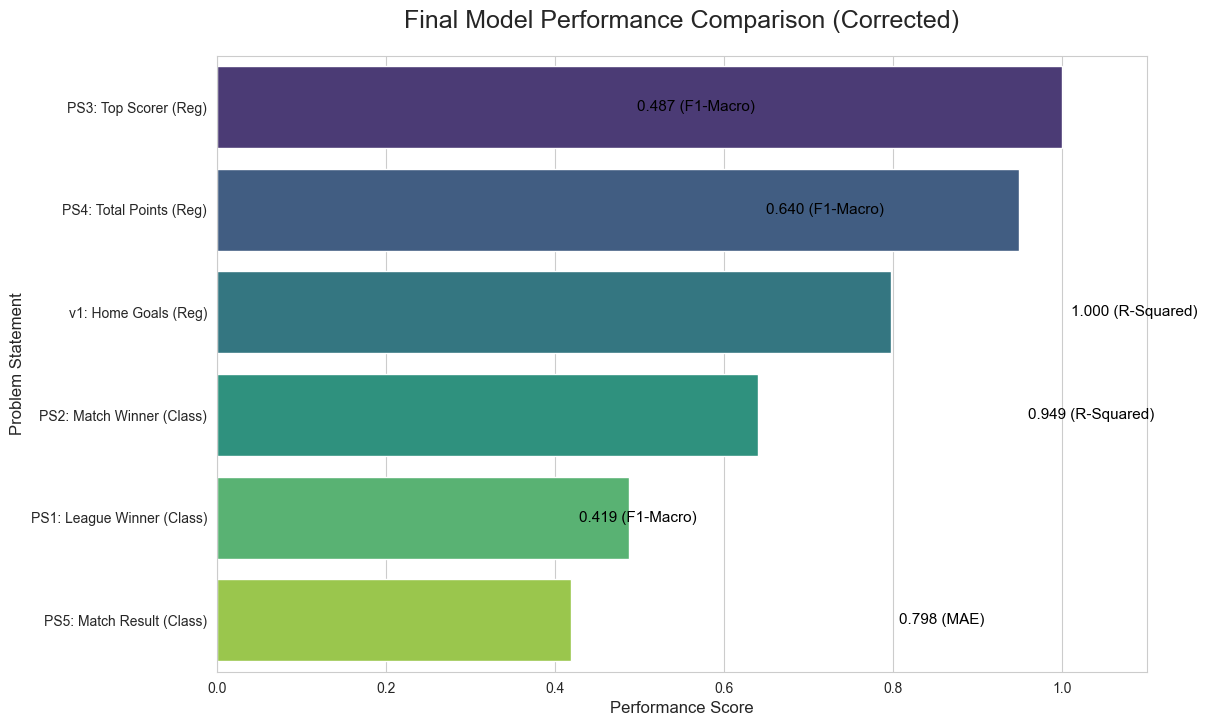


✅ CONSOLIDATED MODEL TRAINING PIPELINE COMPLETE


In [16]:
# --- 5.1: Final Model Performance Comparison ---
print("\n" + "="*80)
print("PART 5: FINAL MODEL PERFORMANCE SUMMARY")
print("="*80)

# Define paths to all metric files
METRICS_PATHS = {
    'PS1: League Winner (Class)': MODELS_DIR / 'ps1_league_winner_metadata.json',
    'PS2: Match Winner (Class)': MODELS_DIR / 'ps2_match_winner_metadata_v4_ultimate.json',
    'PS3: Top Scorer (Reg)': MODELS_DIR / 'ps3_top_scorer_metadata.json',
    'PS4: Total Points (Reg)': MODELS_DIR / 'ps4_total_points_metadata.json',
    'PS5: Match Result (Class)': MODELS_DIR / 'ps5_match_result_metrics.json',
    'v1: Home Goals (Reg)': DATA_ENGINEERED_DIR / 'model_training_summary_v1.json'
}

# --- 5.2: Metric Extraction ---
summary_data = []
print("Loading metrics from all saved models...")

for name, path in METRICS_PATHS.items():
    if not path.exists():
        print(f"  ! Warning: Metric file not found, skipping: {path}")
        continue
        
    try:
        with open(path, 'r') as f:
            metrics = json.load(f)
        
        score = np.nan
        metric_name = "N/A"

        if 'PS1' in name or 'PS2' in name or 'PS5' in name:
            # Classification
            metric_name = 'F1-Macro'
            if 'performance_metrics' in metrics:
                score = metrics['performance_metrics'].get('f1_macro')
            else:
                score = metrics.get('f1_macro')
        
        elif 'PS3' in name or 'PS4' in name:
            # Regression
            metric_name = 'R-Squared'
            if 'performance_metrics' in metrics:
                score = metrics['performance_metrics'].get('test_r2', metrics.get('best_test_r2'))
            else:
                 score = metrics.get('best_test_r2')

        elif 'v1' in name:
            # Regression (MAE was primary)
            metric_name = 'MAE'
            score = metrics.get('best_mae')

        summary_data.append({
            'Model Task': name,
            'Primary Metric': metric_name,
            'Score': score if score is not None else np.nan
        })
        print(f"  ✓ Loaded: {name} (Score: {score:.4f})")
    
    except Exception as e:
        print(f"  ❌ Error loading {name}: {e}")

summary_df = pd.DataFrame(summary_data).dropna().sort_values('Score', ascending=False)

# --- 5.3: Visualization ---
if not summary_df.empty:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create the bar plot
    sns.barplot(x='Score', y='Model Task', data=summary_df, ax=ax, palette='viridis')
    
    # Add score labels
    for index, row in summary_df.iterrows():
        ax.text(row['Score'] + 0.01, index, f"{row['Score']:.3f} ({row['Primary Metric']})", 
                color='black', ha="left", va='center', fontsize=11)
    
    ax.set_title('Final Model Performance Comparison (Corrected)', fontsize=18, pad=20)
    ax.set_xlabel('Performance Score', fontsize=12)
    ax.set_ylabel('Problem Statement', fontsize=12)
    ax.set_xlim(0, max(1.05, summary_df['Score'].max() * 1.1)) # Adjust x-lim
    
    output_path = VIZ_DIR / 'final_model_performance_comparison.png'
    plt.savefig(output_path, bbox_inches='tight')
    
    print(f"\n--- Comparison Chart Generated ---")
    print(summary_df)
    print(f"\n✅ Chart saved to: {output_path}")
    plt.show()
else:
    print("\nNo model metrics were loaded. Skipping summary chart.")

print("\n" + "="*80)
print("✅ CONSOLIDATED MODEL TRAINING PIPELINE COMPLETE")
print("="*80)